In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from datetime import datetime

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers
from tensorflow.keras.utils import to_categorical

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [10]:
df_full = pd.read_pickle("SPY_VIX_cleaned_features.pk")
print(df_full.head(3))

              spy_open    spy_high     spy_low   spy_close  vix_close  \
Date                                                                    
2018-03-14  246.592924  246.779319  243.805775  244.364960      17.23   
2018-03-15  244.879829  245.527783  243.592753  244.098709      16.59   
2018-03-16  244.630687  245.423856  244.309873  244.363342      15.80   

            spy_return_1d  spy_return_5d  spy_return_10d  vix_change_1d  \
Date                                                                      
2018-03-14      -0.005132       0.009238        0.013436       0.053823   
2018-03-15      -0.001090       0.003283        0.027269      -0.037144   
2018-03-16       0.001084      -0.012808        0.023109      -0.047619   

             spy_gap  ...  spy_macd  spy_macd_signal  spy_macd_histogram  \
Date                  ...                                                  
2018-03-14  0.003939  ...  0.761259         0.128807            0.632452   
2018-03-15  0.002107  ...  0.7

In [11]:
print(f"Shape: {df_full.shape}")
print(f"Date Range: {df_full.index[0].date()} to {df_full.index[-1].date()}")

exclude_cols = ['target', 'target_quantile', 'next_day_return']
feature_cols = [col for col in df_full.columns if col not in exclude_cols]

print(f"Total Features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

Shape: (1711, 52)
Date Range: 2018-03-14 to 2024-12-30
Total Features: 49
Features: ['spy_open', 'spy_high', 'spy_low', 'spy_close', 'vix_close', 'spy_return_1d', 'spy_return_5d', 'spy_return_10d', 'vix_change_1d', 'spy_gap', 'spy_overnight_return', 'spy_hl_range', 'spy_sma_5', 'vix_sma_5', 'spy_sma_10', 'vix_sma_10', 'spy_sma_20', 'vix_sma_20', 'spy_sma_50', 'vix_sma_50', 'spy_ema_12', 'spy_ema_26', 'spy_price_to_sma20', 'spy_price_to_sma50', 'vix_price_to_sma10', 'spy_sma5_above_sma20', 'spy_sma20_above_sma50', 'spy_volatility_5d', 'spy_volatility_10d', 'spy_volatility_20d', 'spy_bb_upper', 'spy_bb_lower', 'spy_bb_position', 'vix_relative_to_ma', 'spy_hl_volatility', 'spy_volume', 'spy_volume_ma_10', 'spy_volume_ma_20', 'spy_volume_ratio_10d', 'spy_volume_ratio_20d', 'spy_price_volume_trend', 'spy_rsi_14', 'spy_macd', 'spy_macd_signal', 'spy_macd_histogram', 'spy_momentum_5d', 'spy_momentum_10d', 'spy_price_rank_10d', 'spy_price_rank_20d']


In [12]:
print(f"Dataset Overview:")
print(df_full[feature_cols + ['target']].info())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1711 entries, 2018-03-14 to 2024-12-30
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   spy_open                1711 non-null   float64
 1   spy_high                1711 non-null   float64
 2   spy_low                 1711 non-null   float64
 3   spy_close               1711 non-null   float64
 4   vix_close               1711 non-null   float64
 5   spy_return_1d           1711 non-null   float64
 6   spy_return_5d           1711 non-null   float64
 7   spy_return_10d          1711 non-null   float64
 8   vix_change_1d           1711 non-null   float64
 9   spy_gap                 1711 non-null   float64
 10  spy_overnight_return    1711 non-null   float64
 11  spy_hl_range            1711 non-null   float64
 12  spy_sma_5               1711 non-null   float64
 13  vix_sma_5               1711 non-null   float64
 14  spy_

In [17]:
print(f"\nAnalyzing feature correlations...")
feature_corr = df_full[feature_cols].corr()

# Remove highly correlated features (>0.95)
high_corr_pairs = []
for i in range(len(feature_corr.columns)):
    for j in range(i+1, len(feature_corr.columns)):
        if abs(feature_corr.iloc[i, j]) > 0.95:
            high_corr_pairs.append((feature_corr.columns[i], feature_corr.columns[j], feature_corr.iloc[i, j]))

print(f"High correlation pairs (>0.95): {len(high_corr_pairs)}")
for pair in high_corr_pairs:
    print(f"   {pair[0]} <-> {pair[1]}: {pair[2]:.3f}")


Analyzing feature correlations...
High correlation pairs (>0.95): 75
   spy_open <-> spy_high: 1.000
   spy_open <-> spy_low: 1.000
   spy_open <-> spy_close: 0.999
   spy_open <-> spy_sma_5: 0.999
   spy_open <-> spy_sma_10: 0.998
   spy_open <-> spy_sma_20: 0.996
   spy_open <-> spy_sma_50: 0.990
   spy_open <-> spy_ema_12: 0.998
   spy_open <-> spy_ema_26: 0.996
   spy_open <-> spy_bb_upper: 0.996
   spy_open <-> spy_bb_lower: 0.996
   spy_high <-> spy_low: 1.000
   spy_high <-> spy_close: 1.000
   spy_high <-> spy_sma_5: 0.999
   spy_high <-> spy_sma_10: 0.998
   spy_high <-> spy_sma_20: 0.996
   spy_high <-> spy_sma_50: 0.991
   spy_high <-> spy_ema_12: 0.999
   spy_high <-> spy_ema_26: 0.997
   spy_high <-> spy_bb_upper: 0.996
   spy_high <-> spy_bb_lower: 0.996
   spy_low <-> spy_close: 1.000
   spy_low <-> spy_sma_5: 0.999
   spy_low <-> spy_sma_10: 0.998
   spy_low <-> spy_sma_20: 0.995
   spy_low <-> spy_sma_50: 0.988
   spy_low <-> spy_ema_12: 0.998
   spy_low <-> spy_ema_2

In [14]:
features_to_remove = set()
for pair in high_corr_pairs:
    features_to_remove.add(pair[1])

In [18]:
final_features = [col for col in feature_cols if col not in features_to_remove]
print(f"Final feature count after correlation filtering: {len(final_features)}")

Final feature count after correlation filtering: 29


In [19]:
final_features

['spy_open',
 'vix_close',
 'spy_return_1d',
 'spy_return_5d',
 'spy_return_10d',
 'vix_change_1d',
 'spy_gap',
 'spy_hl_range',
 'vix_sma_50',
 'spy_price_to_sma20',
 'spy_price_to_sma50',
 'vix_price_to_sma10',
 'spy_sma5_above_sma20',
 'spy_sma20_above_sma50',
 'spy_volatility_5d',
 'spy_volatility_10d',
 'spy_volatility_20d',
 'spy_bb_position',
 'spy_volume',
 'spy_volume_ma_10',
 'spy_volume_ma_20',
 'spy_volume_ratio_10d',
 'spy_volume_ratio_20d',
 'spy_rsi_14',
 'spy_macd',
 'spy_macd_signal',
 'spy_macd_histogram',
 'spy_price_rank_10d',
 'spy_price_rank_20d']

In [21]:
print(f"Computing feature importance with Random Forest...")
X_temp = df_full[final_features]
y_temp = df_full['target']

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

# Get top features
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print(f"Top 10 Most Important Features:")
print(feature_importance.head(10))

top_features = feature_importance.head(20)['feature'].tolist()
print(f"\nSelected Top 20 Features for LSTM:")
print(top_features)

Computing feature importance with Random Forest...
Top 10 Most Important Features:
               feature  importance
1            vix_close    0.043950
2        spy_return_1d    0.043401
5        vix_change_1d    0.043319
8           vix_sma_50    0.043040
6              spy_gap    0.042805
11  vix_price_to_sma10    0.042624
14   spy_volatility_5d    0.041917
23          spy_rsi_14    0.041802
7         spy_hl_range    0.041396
3        spy_return_5d    0.040120

Selected Top 20 Features for LSTM:
['vix_close', 'spy_return_1d', 'vix_change_1d', 'vix_sma_50', 'spy_gap', 'vix_price_to_sma10', 'spy_volatility_5d', 'spy_rsi_14', 'spy_hl_range', 'spy_return_5d', 'spy_return_10d', 'spy_volume_ratio_20d', 'spy_price_to_sma20', 'spy_bb_position', 'spy_open', 'spy_macd_histogram', 'spy_price_to_sma50', 'spy_volume_ratio_10d', 'spy_volatility_10d', 'spy_volume']


In [22]:
print("Creating Robust Time-Based Splits")

# Prepare final dataset
X = df_full[top_features].copy()
y = df_full['target'].copy()

print(f"Final dataset shape: X={X.shape}, y={y.shape}")

train_end = '2021-12-31'
val_end = '2023-06-30' 
test_start = '2023-07-01'

train_mask = X.index <= train_end
val_mask = (X.index > train_end) & (X.index <= val_end)
test_mask = X.index > val_end

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Split Summary:")
print(f"   Train: {len(X_train)} samples ({X_train.index[0].date()} to {X_train.index[-1].date()})")
print(f"   Val:   {len(X_val)} samples ({X_val.index[0].date()} to {X_val.index[-1].date()})")
print(f"   Test:  {len(X_test)} samples ({X_test.index[0].date()} to {X_test.index[-1].date()})")

for split_name, y_split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    dist = y_split.value_counts().sort_index()
    print(f"\n   {split_name} Distribution:")
    for i, count in dist.items():
        pct = count / len(y_split) * 100
        print(f"     {['Neg', 'Neu', 'Pos'][i]}: {count} ({pct:.1f}%)")

Creating Robust Time-Based Splits
Final dataset shape: X=(1711, 20), y=(1711,)
Split Summary:
   Train: 959 samples (2018-03-14 to 2021-12-31)
   Val:   375 samples (2022-01-03 to 2023-06-30)
   Test:  377 samples (2023-07-03 to 2024-12-30)

   Train Distribution:
     Neg: 362 (37.7%)
     Neu: 206 (21.5%)
     Pos: 391 (40.8%)

   Val Distribution:
     Neg: 184 (49.1%)
     Neu: 44 (11.7%)
     Pos: 147 (39.2%)

   Test Distribution:
     Neg: 140 (37.1%)
     Neu: 91 (24.1%)
     Pos: 146 (38.7%)


In [23]:
print("Feature Scaling...")

# RobustScaler for better handling of outliers in financial data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print(f"Features scaled using RobustScaler")
print(f"Scaling example - Feature 0:")
print(f"   Original: mean={X_train.iloc[:, 0].mean():.4f}, std={X_train.iloc[:, 0].std():.4f}")
print(f"   Scaled:   mean={X_train_scaled[:, 0].mean():.4f}, std={X_train_scaled[:, 0].std():.4f}")


Feature Scaling...
Features scaled using RobustScaler
Scaling example - Feature 0:
   Original: mean=20.4265, std=8.9565
   Scaled:   mean=0.2997, std=1.0877


In [24]:
print("Computing Class Weights for Imbalanced Data...")

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print(f"Class Weights:")
for i, weight in class_weight_dict.items():
    class_name = ['Negative', 'Neutral', 'Positive'][i]
    print(f"   {class_name} ({i}): {weight:.3f}")

Computing Class Weights for Imbalanced Data...
Class Weights:
   Negative (0): 0.883
   Neutral (1): 1.552
   Positive (2): 0.818


In [26]:
print("Creating Sequences for LSTM")

def create_sequences(X, y, sequence_length=15, step=1):
    
    X_seq, y_seq, indices = [], [], []
    
    for i in range(sequence_length, len(X), step):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y.iloc[i])
        indices.append(y.index[i])
    
    return np.array(X_seq), np.array(y_seq), indices

# Creating sequences with 15-day lookback window
sequence_length = 15
print(f"Using sequence length: {sequence_length} days")

X_train_seq, y_train_seq, train_indices = create_sequences(X_train_scaled_df, y_train, sequence_length)
X_val_seq, y_val_seq, val_indices = create_sequences(X_val_scaled_df, y_val, sequence_length)
X_test_seq, y_test_seq, test_indices = create_sequences(X_test_scaled_df, y_test, sequence_length)

print(f"Sequence Shapes:")
print(f"   Train: X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"   Val:   X={X_val_seq.shape}, y={y_val_seq.shape}")
print(f"   Test:  X={X_test_seq.shape}, y={y_test_seq.shape}")

seq_class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
seq_class_weight_dict = dict(enumerate(seq_class_weights))

Creating Sequences for LSTM
Using sequence length: 15 days
Sequence Shapes:
   Train: X=(944, 15, 20), y=(944,)
   Val:   X=(360, 15, 20), y=(360,)
   Test:  X=(362, 15, 20), y=(362,)


In [28]:
print("Building Improved Baseline Neural Network...")

def improved_baseline(input_dim, num_classes=3):
    """
    Improved baseline with better regularization
    """
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.BatchNormalization(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.BatchNormalization(),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

baseline_model = improved_baseline(len(top_features))
baseline_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Baseline Model Architecture:")
baseline_model.summary()

Building Improved Baseline Neural Network...
Baseline Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,971 (54.57 KB)

 Trainable params: 13,547 (52.92 KB)

 Non-trainable params: 424 (1.66 KB)

In [30]:
print("Training Improved Baseline Model")

baseline_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_baseline_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(f"Starting baseline training...")
baseline_history = baseline_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=baseline_callbacks,
    class_weight=class_weight_dict,
    verbose=0
)

baseline_val_acc = max(baseline_history.history['val_accuracy'])
baseline_val_loss = min(baseline_history.history['val_loss'])

print(f"Baseline Results:")
print(f"   Best Validation Accuracy: {baseline_val_acc:.4f}")
print(f"   Best Validation Loss: {baseline_val_loss:.4f}")

Training Improved Baseline Model
Starting baseline training...

Epoch 1: val_accuracy improved from -inf to 0.44533, saving model to best_baseline_model.h5



Epoch 2: val_accuracy did not improve from 0.44533

Epoch 3: val_accuracy improved from 0.44533 to 0.45867, saving model to best_baseline_model.h5



Epoch 4: val_accuracy did not improve from 0.45867

Epoch 5: val_accuracy did not improve from 0.45867

Epoch 6: val_accuracy did not improve from 0.45867

Epoch 7: val_accuracy did not improve from 0.45867

Epoch 8: val_accuracy did not improve from 0.45867

Epoch 9: val_accuracy did not improve from 0.45867

Epoch 10: val_accuracy did not improve from 0.45867

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy did not improve from 0.45867

Epoch 12: val_accuracy did not improve from 0.45867

Epoch 13: val_accuracy did not improve from 0.45867

Epoch 14: val_accuracy did not improve from 0.45867

Epoch 15: val_accuracy did not improve from 0.45867

Epoch 16: val_accuracy did not improve from 0.45867

Epoch 17: val_accuracy did not improve from 0.45867

Epoch 18: val_accuracy did not improve from 0.45867
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 3.
Baseline Results:
   Best Validation Accuracy: 0.

In [39]:
print("Building Advanced LSTM Model...")

def model_lstm(sequence_length, num_features, num_classes=3):
    
    model = tf.keras.Sequential([
        layers.Input(shape=(sequence_length, num_features)),
        
        # First LSTM layer with return sequences
        layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Second LSTM layer with return sequences
        layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Final LSTM layer
        layers.LSTM(16, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Dense layers with regularization
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.4),
        
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

lstm_model = model_lstm(sequence_length, len(top_features))

lstm_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"LSTM Model Architecture:")
lstm_model.summary()

Building Advanced LSTM Model...
LSTM Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 64)              │          21,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 15, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 15, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 15, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,883 (151.89 KB)

 Trainable params: 38,659 (151.01 KB)

 Non-trainable params: 224 (896.00 B)

In [40]:
print("\nTraining LSTM Model...")

# LSTM callbacks
lstm_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_lstm_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train
print(f"\nStarting training")
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=30,  
    callbacks=lstm_callbacks,
    class_weight=seq_class_weight_dict,
    verbose=1
)

lstm_val_acc = max(lstm_history.history['val_accuracy'])
lstm_val_loss = min(lstm_history.history['val_loss'])


Training LSTM Model...

Starting training
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3334 - loss: 1.2341
Epoch 1: val_accuracy improved from -inf to 0.25833, saving model to best_lstm_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.3332 - loss: 1.2352 - val_accuracy: 0.2583 - val_loss: 1.1047 - learning_rate: 5.0000e-04
Epoch 2/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3420 - loss: 1.2058
Epoch 2: val_accuracy did not improve from 0.25833
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3417 - loss: 1.2058 - val_accuracy: 0.2306 - val_loss: 1.1075 - learning_rate: 5.0000e-04
Epoch 3/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3319 - loss: 1.1547
Epoch 3: val_accuracy did not improve from 0.25833
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.3313 - loss: 1.1550 - val_accuracy: 0.2361 - val_loss: 1.1120 - learning_rate: 5.0000e-04
Epoch 4/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3322 - loss: 1.1430
Epoch 4: val_accuracy did not improve from 0.25833
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3314 - loss: 1.1434 - val_accuracy: 0.2167 - val_loss: 1.1180 - learning_rate: 5.0000e-04
Epoch 5/100

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3523 - loss: 1.0991 - val_accuracy: 0.3167 - val_loss: 1.1083 - learning_rate: 5.0000e-04
Epoch 8/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3286 - loss: 1.1252
Epoch 8: val_accuracy improved from 0.31667 to 0.33333, saving model to best_lstm_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3283 - loss: 1.1258 - val_accuracy: 0.3333 - val_loss: 1.1013 - learning_rate: 5.0000e-04
Epoch 9/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3580 - loss: 1.1232
Epoch 9: val_accuracy improved from 0.33333 to 0.34444, saving model to best_lstm_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3582 - loss: 1.1225 - val_accuracy: 0.3444 - val_loss: 1.0988 - learning_rate: 5.0000e-04
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3573 - loss: 1.1187
Epoch 10: val_accuracy improved from 0.34444 to 0.36389, saving model to best_lstm_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.3572 - loss: 1.1186 - val_accuracy: 0.3639 - val_loss: 1.0954 - learning_rate: 5.0000e-04
Epoch 11/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3379 - loss: 1.1085
Epoch 11: val_accuracy did not improve from 0.36389
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3373 - loss: 1.1090 - val_accuracy: 0.3472 - val_loss: 1.1037 - learning_rate: 5.0000e-04
Epoch 12/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3376 - loss: 1.0975
Epoch 12: val_accuracy did not improve from 0.36389
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3370 - loss: 1.0985 - val_accuracy: 0.3556 - val_loss: 1.1058 - learning_rate: 5.0000e-04
Epoch 13/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3328 - loss: 1.1102
Epoch 13: val_accuracy did not improve from 0.36389
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3327 - loss: 1.1105 - val_accuracy: 0.3500 - val_loss: 1.1014 - learning_rate: 5.0000e-04
Epoch 1

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3103 - loss: 1.0995 - val_accuracy: 0.3667 - val_loss: 1.0970 - learning_rate: 5.0000e-04
Epoch 17/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3578 - loss: 1.0905
Epoch 17: val_accuracy improved from 0.36667 to 0.36944, saving model to best_lstm_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3586 - loss: 1.0913 - val_accuracy: 0.3694 - val_loss: 1.1072 - learning_rate: 5.0000e-04
Epoch 18/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3430 - loss: 1.1225
Epoch 18: val_accuracy did not improve from 0.36944
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3424 - loss: 1.1222 - val_accuracy: 0.3611 - val_loss: 1.0974 - learning_rate: 5.0000e-04
Epoch 19/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3445 - loss: 1.1040
Epoch 19: val_accuracy improved from 0.36944 to 0.37500, saving model to best_lstm_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.3446 - loss: 1.1041 - val_accuracy: 0.3750 - val_loss: 1.0932 - learning_rate: 5.0000e-04
Epoch 20/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3508 - loss: 1.0983
Epoch 20: val_accuracy did not improve from 0.37500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3508 - loss: 1.0987 - val_accuracy: 0.3472 - val_loss: 1.0945 - learning_rate: 5.0000e-04
Epoch 21/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3104 - loss: 1.1075
Epoch 21: val_accuracy did not improve from 0.37500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3118 - loss: 1.1071 - val_accuracy: 0.3667 - val_loss: 1.0950 - learning_rate: 5.0000e-04
Epoch 22/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3201 - loss: 1.1127
Epoch 22: val_accuracy did not improve from 0.37500
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3202 - loss: 1.1124 - val_accuracy: 0.3639 - val_loss: 1.0888 - learning_rate: 5.0000e-04
Epoch 2

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3637 - loss: 1.1038 - val_accuracy: 0.3917 - val_loss: 1.0829 - learning_rate: 5.0000e-04
Epoch 26/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3581 - loss: 1.0982
Epoch 26: val_accuracy did not improve from 0.39167
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3582 - loss: 1.0981 - val_accuracy: 0.3722 - val_loss: 1.0845 - learning_rate: 5.0000e-04
Epoch 27/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3711 - loss: 1.0835
Epoch 27: val_accuracy did not improve from 0.39167
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3710 - loss: 1.0839 - val_accuracy: 0.3750 - val_loss: 1.0850 - learning_rate: 5.0000e-04
Epoch 28/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3577 - loss: 1.0890
Epoch 28: val_accuracy did not improve from 0.39167
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3574 - loss: 1.0890 - val_accuracy: 0.3722 - val_loss: 1.0775 - learning_rate: 5.0000e-04
Epoch 2

In [41]:
print(f"\nLSTM Results:")
print(f"   Best Validation Accuracy: {lstm_val_acc:.4f}")
print(f"   Best Validation Loss: {lstm_val_loss:.4f}")


LSTM Results:
   Best Validation Accuracy: 0.3917
   Best Validation Loss: 1.0611


In [42]:
print(f"Testing both models on test data")

# Baseline test
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test_scaled, y_test, verbose=0)
baseline_test_pred = baseline_model.predict(X_test_scaled, verbose=0)
baseline_test_pred_classes = np.argmax(baseline_test_pred, axis=1)

# LSTM test
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)
lstm_test_pred = lstm_model.predict(X_test_seq, verbose=0)
lstm_test_pred_classes = np.argmax(lstm_test_pred, axis=1)

print(f"Test Set Results:")
print(f"   Baseline - Accuracy: {baseline_test_acc:.4f}, Loss: {baseline_test_loss:.4f}")
print(f"   LSTM     - Accuracy: {lstm_test_acc:.4f}, Loss: {lstm_test_loss:.4f}")

Testing both models on test data
Test Set Results:
   Baseline - Accuracy: 0.3767, Loss: 1.0797
   LSTM     - Accuracy: 0.3039, Loss: 1.1067


In [43]:
# Classification results
print(f"\nBaseline Classification Report:")
print(classification_report(y_test, baseline_test_pred_classes, 
                          target_names=['Negative', 'Neutral', 'Positive']))

print(f"\nLSTM Classification Report:")
print(classification_report(y_test_seq, lstm_test_pred_classes, 
                          target_names=['Negative', 'Neutral', 'Positive']))


Baseline Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.33      0.36       140
     Neutral       0.30      0.54      0.38        91
    Positive       0.48      0.32      0.39       146

    accuracy                           0.38       377
   macro avg       0.39      0.40      0.38       377
weighted avg       0.41      0.38      0.38       377


LSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.02      0.04       136
     Neutral       0.25      0.72      0.37        86
    Positive       0.41      0.32      0.36       140

    accuracy                           0.30       362
   macro avg       0.42      0.35      0.26       362
weighted avg       0.44      0.30      0.24       362



***USING A MORE BALANCED LSTM APPROACH***
-

In [44]:
from collections import Counter
def calculate_balanced_weights(y_train_seq):
    
    class_counts = Counter(y_train_seq)
    total_samples = len(y_train_seq)
    
    weights = {}
    for class_id in [0, 1, 2]:
        if class_id in class_counts and class_counts[class_id] > 0:
            weights[class_id] = total_samples / (3 * class_counts[class_id])
        else:
            weights[class_id] = 1.0   
    if 1 in weights:
        weights[1] *= 0.8 
    
    print(f"Balanced Class Weights:")
    for class_id, weight in weights.items():
        class_name = ['Negative', 'Neutral', 'Positive'][class_id]
        count = class_counts.get(class_id, 0)
        print(f"   {class_name}: {weight:.3f} (count: {count})")
    
    return weights

In [45]:
def create_optimal_lstm(sequence_length, num_features, num_classes=3):

    model = tf.keras.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, num_features)),
        
        # LSTM layers with moderate complexity
        layers.LSTM(48, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        layers.LSTM(24, dropout=0.2, recurrent_dropout=0.2),
        layers.BatchNormalization(),
        
        # Dense layers with balanced regularization
        layers.Dense(24, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(12, activation='relu'),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

In [46]:
def create_sample_weights(y_train_seq):
    
    class_counts = Counter(y_train_seq)
    total_samples = len(y_train_seq)
    
    # Calculating weight for each sample
    sample_weights = np.zeros(len(y_train_seq))
    
    for i, class_label in enumerate(y_train_seq):
        # Standard balanced weight
        weight = total_samples / (3 * class_counts[class_label])
        # Adding small random variation to prevent overfitting
        weight *= np.random.uniform(0.9, 1.1)
        sample_weights[i] = weight
    
    return sample_weights

In [50]:
def train_optimized_lstm(X_train_seq, y_train_seq, X_val_seq, y_val_seq, 
                        sequence_length, num_features):
    
    print("Training Optimized LSTM")
    
    model = create_optimal_lstm(sequence_length, num_features)
    
    class_weights = calculate_balanced_weights(y_train_seq)
    
    sample_weights = create_sample_weights(y_train_seq)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0008),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    print("Starting Optimized Training...")
    
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=60,
        batch_size=16,
        class_weight=class_weights,
        callbacks=callbacks_list,
        verbose=1
    )
    
    return model, history

***CODE TO RUN BALANCED LSTM AND CREATE ENSEMBLE MODEL WITH BASELINE***
-

In [51]:
optimized_lstm_model, optimized_history = train_optimized_lstm(
    X_train_seq, y_train_seq, 
    X_val_seq, y_val_seq, 
    sequence_length, len(top_features)
)

Training Optimized LSTM
Balanced Class Weights:
   Negative: 0.889 (count: 354)
   Neutral: 1.234 (count: 204)
   Positive: 0.815 (count: 386)
Starting Optimized Training...
Epoch 1/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.2938 - loss: 1.2059 - val_accuracy: 0.3917 - val_loss: 1.0940 - learning_rate: 8.0000e-04
Epoch 2/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3056 - loss: 1.0793 - val_accuracy: 0.4250 - val_loss: 1.0851 - learning_rate: 8.0000e-04
Epoch 3/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3565 - loss: 1.0611 - val_accuracy: 0.3944 - val_loss: 1.0805 - learning_rate: 8.0000e-04
Epoch 4/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3859 - loss: 1.0300 - val_accuracy: 0.4222 - val_loss: 1.0768 - learning_rate: 8.0000e-04
Epoch 5/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3818 - loss: 1.0331 - val_accuracy: 0.4167 - val_loss: 1.0754 - learning_rate: 8.0000e-04
Epoch 6/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step 

In [52]:
optimized_lstm_pred_proba = optimized_lstm_model.predict(X_test_seq, verbose=0)
optimized_lstm_pred = np.argmax(optimized_lstm_pred_proba, axis=1)

# Calculate accuracy
from sklearn.metrics import accuracy_score, classification_report
optimized_lstm_accuracy = accuracy_score(y_test_seq, optimized_lstm_pred)

print(f"Optimized LSTM Test Accuracy: {optimized_lstm_accuracy:.4f}")

print(f"\nOptimized LSTM Classification Report:")
print(classification_report(y_test_seq, optimized_lstm_pred, 
                          target_names=['Negative', 'Neutral', 'Positive']))

Optimized LSTM Test Accuracy: 0.4171

Optimized LSTM Classification Report:
              precision    recall  f1-score   support

    Negative       0.40      0.85      0.55       136
     Neutral       0.31      0.05      0.08        86
    Positive       0.50      0.22      0.31       140

    accuracy                           0.42       362
   macro avg       0.40      0.37      0.31       362
weighted avg       0.42      0.42      0.34       362



In [53]:
print(f"\n📈 Performance Comparison:")
print(f"{'Model':<20} {'Accuracy':<10} {'Improvement'}")
print(f"{'='*40}")
print(f"{'Baseline NN':<20} {0.38:<10.4f} {'Reference'}")
print(f"{'Previous LSTM':<20} {0.30:<10.4f} {'-8.0pp'}")
print(f"{'Optimized LSTM':<20} {optimized_lstm_accuracy:<10.4f} {f'{(optimized_lstm_accuracy-0.30)*100:+.1f}pp'}")


📈 Performance Comparison:
Model                Accuracy   Improvement
Baseline NN          0.3800     Reference
Previous LSTM        0.3000     -8.0pp
Optimized LSTM       0.4171     +11.7pp


***PLOTTING RESULTS AND MODEL ANALYSIS***
-

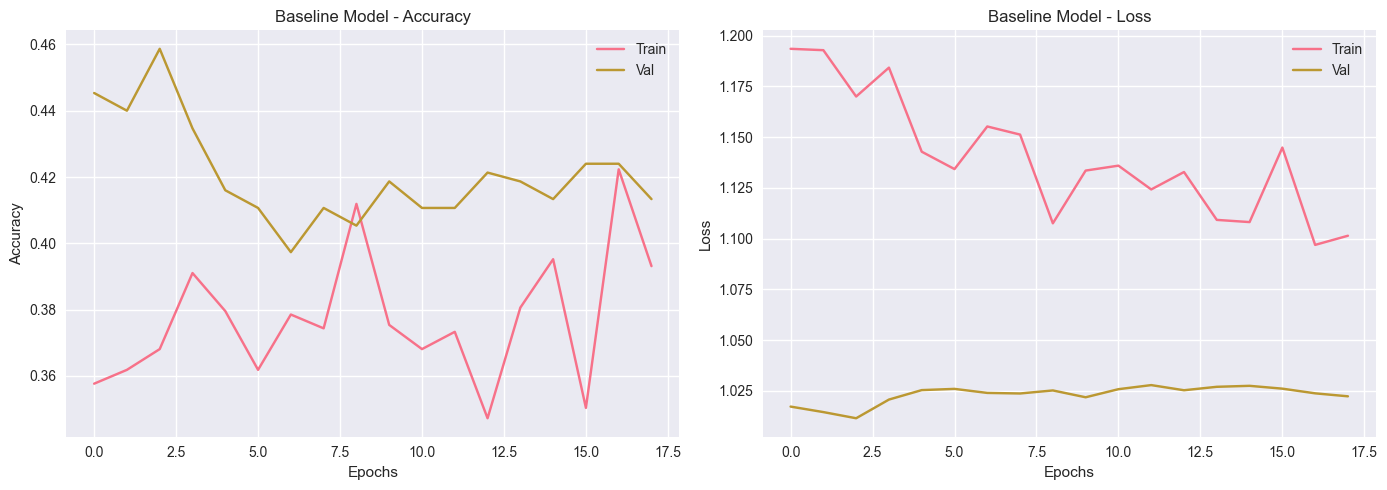

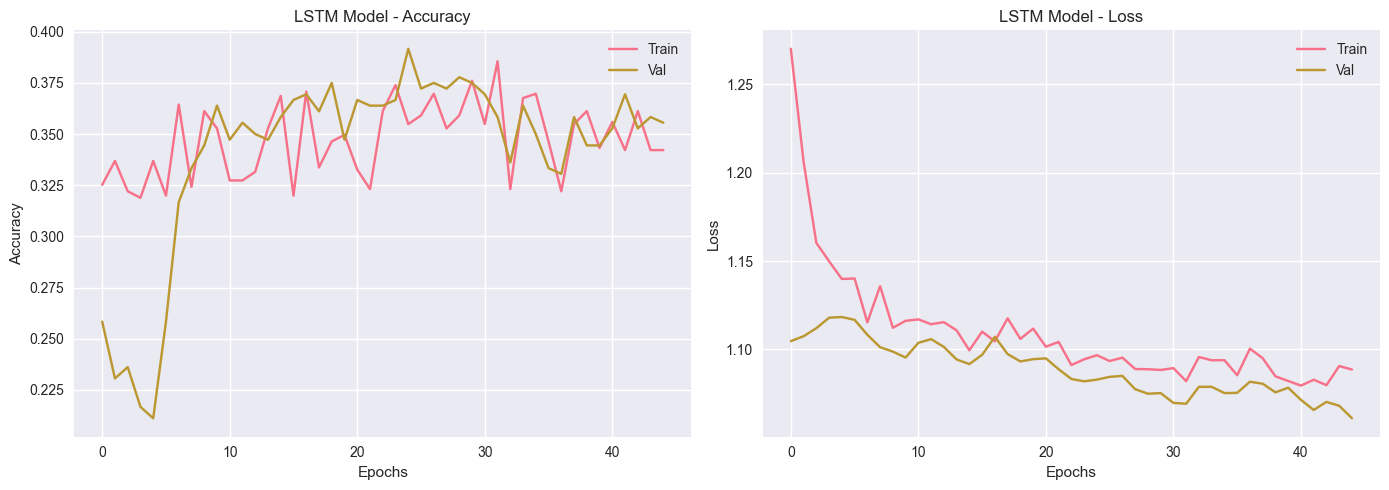

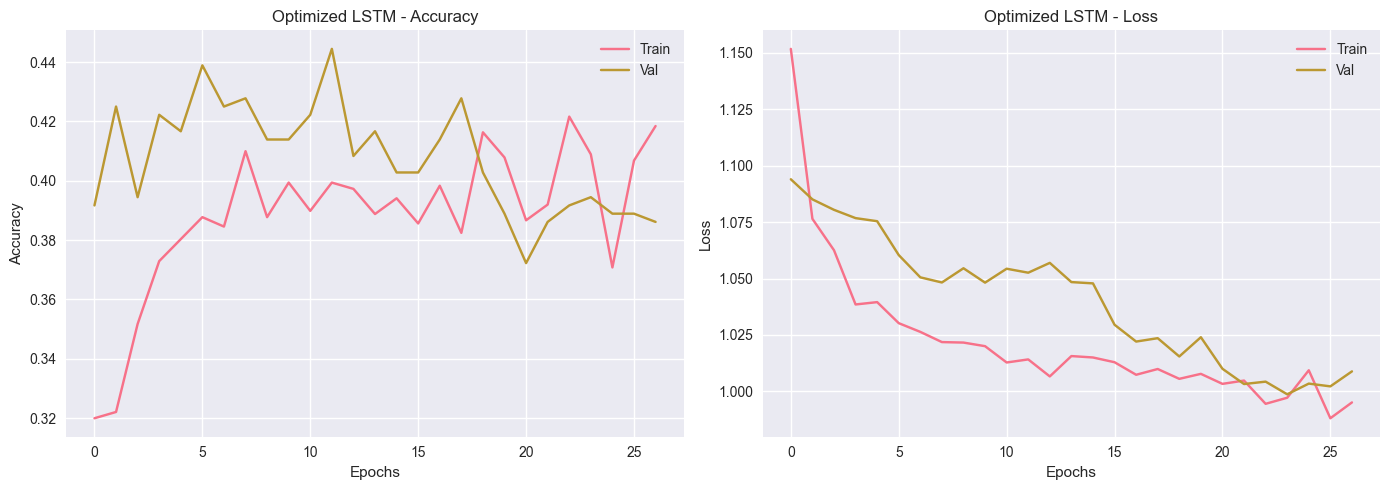

In [60]:
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(baseline_history, "Baseline Model")
plot_training_history(lstm_history, "LSTM Model")
plot_training_history(optimized_history, "Optimized LSTM")

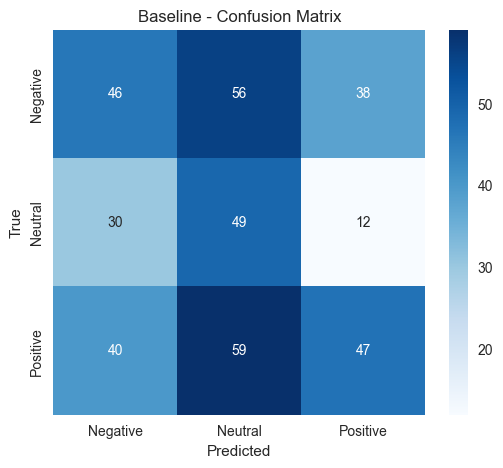

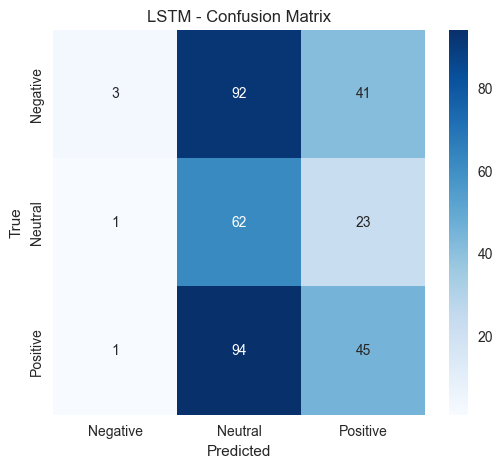

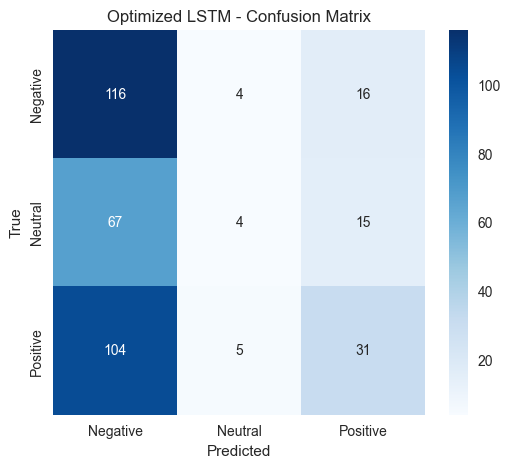

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Negative', 'Neutral', 'Positive']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


plot_confusion(y_test, baseline_test_pred_classes, "Baseline")
plot_confusion(y_test_seq, lstm_test_pred_classes, "LSTM")
plot_confusion(y_test_seq, optimized_lstm_pred, "Optimized LSTM")